https://www.bilibili.com/video/BV1UK4y1o7dy?p=2

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

import d2l_torch as d2l
import torch 
from torch import nn

生成数据

生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

+ 我们选择标签是关于输入的线性函数。
+ 标签同时被均值为0，标准差为0.01高斯噪声破坏。
+ 为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。


In [6]:
n_train,n_test,num_inputs,batch_size=20,100,200,5

true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05

train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)

test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size,is_train=False)

## 从0实现

初始化模型参数

In [7]:
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

定义L2范数惩罚

L2最简单的一种实现就是直接平方和，不用再进行开根号，除以2是因为之后为了和求导多出来的2这个常数项约掉。

这里没有把惩罚项/拉格朗日算子$\lambda$写进去，之后调用的时候再写

L2范数是加在损失函数中的

In [8]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

训练代码的函数实现

(这里直接把模型和损失函数的实现放在训练集里，直接调用之前的线性函数的定义，和MAE均方损失误差了)

In [9]:
def train(lambd):
    w,b =init_params()
    net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.03
    animator=d2l.Animator(xlabel="epochs",ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=["train","test"])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # with torch.enable_grad(): # 不需要这句了，默认就是启动梯度计算的
            l=loss(net(X),y)+lambd*l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

 开始训练
 
 第一次先看没有惩罚项的损失函数的情况，可以看到非常明显的过拟合。。。。
 
 此时W的L2范数是13.7，可以看出来，很大！
 `torch.norm `默认的是F范数也就是L2范数  可以参考：[torch.norm的理解](https://blog.csdn.net/goodxin_ie/article/details/84657975)

In [14]:
w=torch.tensor([3.0,4.0])
torch.norm(w)

tensor(5.)

w的L2范数是： 13.711645126342773


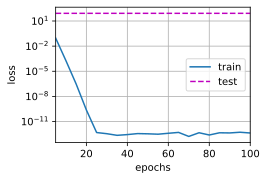

In [10]:
train(0) 

接下来看$\lambda=3$时候的效果，可以看到，一定程度上扼制了过拟合现象。

w的L2范数是： 0.03915635123848915


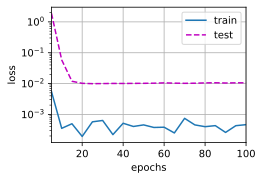

In [11]:
train(3) 

w的真实值是0.01，所以其实$\lambda=3$还是惩罚不够，还可以继续惩罚

w的L2范数是： 0.017621001228690147


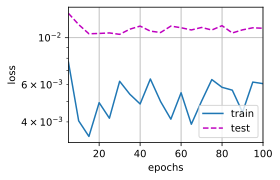

In [24]:
train(20) 

可以尝试使用不同的$\lambda$看看，其实也没有办法完全解决过拟合，但是巡林和预测的效果不会差那么多

## 简单实现

主要区别是在SGD中，可以看到，weight_decay被直接放在SGD中了。

几乎所有的优化算法里面都会有这个weight_decay参数，就是L2正则，就是加一个乘积项目而已，也很好实现

```bash
Args:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float): learning rate
    momentum (float, optional): momentum factor (default: 0)
    weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    dampening (float, optional): dampening for momentum (default: 0)
    nesterov (bool, optional): enables Nesterov momentum (default: False)
```

简单来说，weight_decay就是在更新参数之前，先给前面有个小的乘积，其公式是

$$w_t=(1-a\lambda)w_{t-1}-\frac{\partial XXX}{\partial w_{t-1}}$$

所以L2的惩罚项，真正起作用的时候，还受到学习率的限制，上面的a是learning rate，所以l2惩罚项可以适当大一些

In [25]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。 
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 15.483811378479004


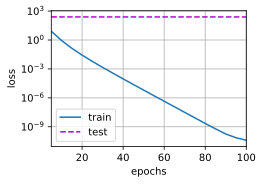

In [27]:
train_concise(0)

其实简洁实现和从0实现效果其实差不多，但是运行速度会更快一些

w的L2范数： 4.136290550231934


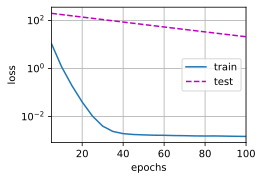

In [28]:
train_concise(1)

## 改成L1范数试试

In [29]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [34]:
def train(lambd):
    w,b =init_params()
    net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.03
    animator=d2l.Animator(xlabel="epochs",ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=["train","test"])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # with torch.enable_grad(): # 不需要这句了，默认就是启动梯度计算的
            l=loss(net(X),y)+lambd*l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L1范数是：', torch.norm(w).item())

w的L1范数是： 13.532822608947754


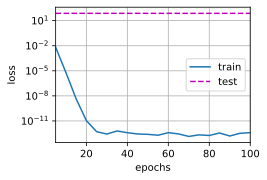

In [35]:
train(0)

w的L1范数是： 0.2734774649143219


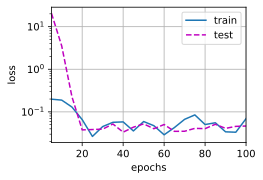

In [36]:
train(1)

看起来过拟合效果好了很多，哈哈哈